In [2]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns
from scipy.stats import f_oneway
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform 
from dtw import accelerated_dtw

from bin import utils

In [3]:
fdata = sc.read_h5ad("./RNA/spatial.combined.clustered.h5")
gdata = sc.read_h5ad("./RNA/spatial.filtered.guide.bin100.h5")

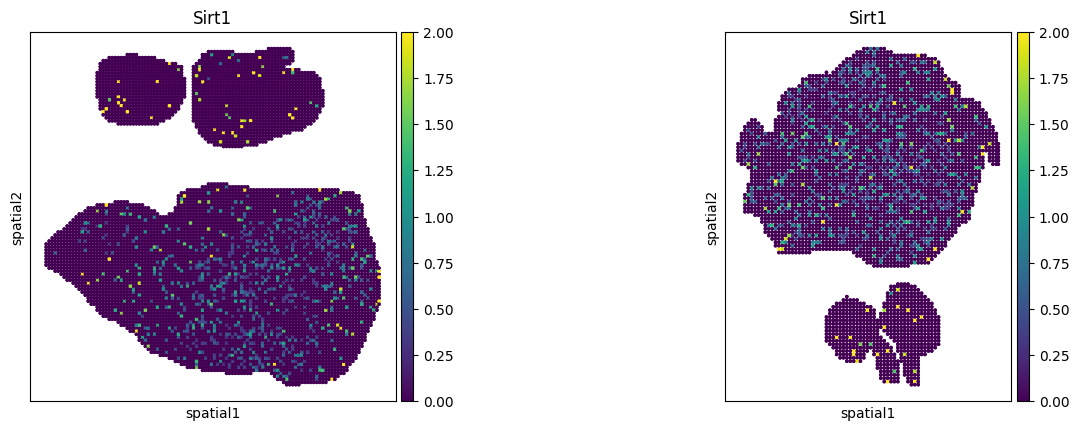

In [6]:
sq.pl.spatial_scatter(fdata, color='Sirt1', shape=None, size=10, library_key='marker', vmax=2)

In [4]:
fdata = fdata[:, ~fdata.var_names.str.startswith('sg')].copy()

In [5]:
fdata.obs['coord_x'] = fdata.obsm['spatial'][:, 0] // 100 * 100
fdata.obs['coord_y'] = fdata.obsm['spatial'][:, 1] // 100 * 100

gdata.obs['coord_x'] = gdata.obsm['spatial'][:, 0] // 100 * 100
gdata.obs['coord_y'] = gdata.obsm['spatial'][:, 1] // 100 * 100
fdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(fdata.obs['marker'], fdata.obs['coord_x'], fdata.obs['coord_y'])]
gdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(gdata.obs['marker'], gdata.obs['coord_x'], gdata.obs['coord_y'])]

common_bins = np.intersect1d(fdata.obs_names, gdata.obs_names)
fdata = fdata[common_bins].copy()
gdata = gdata[common_bins].copy()

# Correlation

In [8]:
sgs = gdata.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(gdata.X.toarray(), columns=gdata.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=gdata.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = gdata.obsm['spatial']
gdata = sgdata.copy()

/tmp/ipykernel_12409/3215762596.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


F_onewayResult(statistic=3.0690312317110684, pvalue=0.08093653736720477)


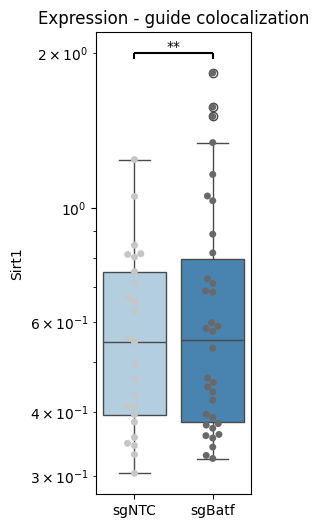

In [66]:
from scipy.stats import spearmanr, pearsonr, f_oneway

# gene_vec = fdata[:, 'Sirt1'].X.toarray().flatten()
ntc_vec = fdata[gdata[:, 'sgnon-targeting'].X > 1, 'Sirt1'].X.toarray().flatten()
guide_vec = fdata[gdata[:, 'sgBatf'].X > 0, 'Sirt1'].X.toarray().flatten()

print(f_oneway(ntc_vec, guide_vec))

import seaborn as sns
plt.figure(figsize=(2,6))
sns.boxplot([ntc_vec[ntc_vec > 0], guide_vec[guide_vec > 0]], palette='Blues')
sns.swarmplot([ntc_vec[ntc_vec > 0], guide_vec[guide_vec > 0]], palette='Greys')
plt.title('Expression - guide colocalization')
plt.ylabel('Sirt1')
plt.xticks([0, 1], ['sgNTC', 'sgBatf'])
plt.hlines(xmin=0, xmax=1, y=2, color='black')
plt.vlines(x=0, ymin=1.95, ymax=2, color='black')
plt.vlines(x=1, ymin=1.95, ymax=2, color='black')
plt.text(x=0.5, ha='center', y=2.02, s='**')
plt.gca().set_yscale('log')

In [67]:
Apoptosis_genes = ["Add1", "Aifm3", "Ank", "Anxa1", "App", "Atf3", "Avpr1a", "Bax", "Bcap31", "Bcl10", "Bcl2l1", "Bcl2l10", "Bcl2l11", "Bcl2l2", "Bgn", "Bid", "Bik", "Birc3", "Bmf", "Bmp2", "Bnip3l", "Brca1", "Btg2", "Btg3", "Casp1", "Casp2", "Casp3", "Casp4", "Casp6", "Casp7", "Casp8", "Casp9", "Cav1", "Ccna1", "Ccnd1", "Ccnd2", "Cd14", "Cd2", "Cd38", "Cd44", "Cd69", "Cdc25b", "Cdk2", "Cdkn1a", "Cdkn1b", "Cflar", "Clu", "Crebbp", "Cth", "Ctnnb1", "Cyld", "Dap", "Dap3", "Dcn", "Ddit3", "Dffa", "Diablo", "Dnaja1", "Dnajc3", "Dnm1l", "Dpyd", "Ebp", "Egr3", "Emp1", "Eno2", "Erbb2", "Erbb3", "Ereg", "Etf1", "F2", "F2r", "Fas", "Fasl", "Fdxr", "Fez1", "Gadd45a", "Gadd45b", "Gch1", "Gna15", "Gpx1", "Gpx3", "Gpx4", "Gsn", "Gsr", "Gstm2", "Gucy2e", "H1f0", "Hgf", "Hmgb2", "Hmox1", "Hspb1", "Ier3", "Ifitm3", "Ifnb1", "Ifngr1", "Igf2r", "Igfbp6", "Il18", "Il1a", "Il1b", "Il6", "Irf1", "Isg20", "Jun", "Krt18", "Lef1", "Lgals3", "Lmna", "Lum", "Madd", "Mcl1", "Mgmt", "Mmp2", "Nedd9", "Nefh", "Pak1", "Pdcd4", "Pdgfrb", "Pea15a", "Plat", "Plcb2", "Plppr4", "Pmaip1", "Ppp2r5b", "Ppp3r1", "Ppt1", "Prf1", "Psen1", "Psen2", "Ptk2", "Rara", "Rela", "Retsat", "Rhob", "Rhot2", "Rnasel", "Rock1", "Sat1", "Satb1", "Sc5d", "Slc20a1", "Smad7", "Sod1", "Sod2", "Sptan1", "Sqstm1", "Tap1", "Tgfb2", "Tgfbr3", "Timp1", "Timp2", "Timp3", "Tnf", "Tnfrsf12a", "Tnfsf10", "Top2a", "Tspo", "Txnip", "Vdac2", "Wee1", "Xiap"]
Oxidative_phosphoralation_genes = ["Abcb7", "Acaa1a", "Acaa2", "Acadm", "Acadsb", "Acadvl", "Acat1", "Aco2", "Afg3l2", "Aifm1", "AK157302", "Alas1", "Aldh6a1", "Atp1b1", "Atp5f1a", "Atp5f1b", "Atp5f1c", "Atp5f1d", "Atp5f1e", "Atp5mc1", "Atp5mc3", "Atp5me", "Atp5mf", "Atp5pb", "Atp5pd", "Atp5pf", "Atp5po", "Atp6ap1", "Atp6v0b", "Atp6v0c", "Atp6v0e", "Atp6v1c1", "Atp6v1d", "Atp6v1e1", "Atp6v1f", "Atp6v1g1", "Atp6v1h", "Bax", "Bckdha", "Bdh2", "Casp7", "Cox10", "Cox11", "Cox15", "Cox17", "Cox4i1", "Cox5a", "Cox5b", "Cox6a1", "Cox6b1", "Cox6c", "Cox7a2", "Cox7a2l", "Cox7b", "Cox7c", "Cox8a", "Cpt1a", "Cs", "Cyb5a", "Cyb5r3", "Cyc1", "Decr1", "Dlat", "Dld", "Dlst", "Ech1", "Echs1", "Eci1", "Etfa", "Etfb", "Etfdh", "Fdx1", "Fh1", "Fxn", "Glud1", "Gm10053", "Got2", "Gpi1", "Gpx4", "Grpel1", "Hadha", "Hadhb", "Hccs", "Hsd17b10", "Hspa9", "Htra2", "Idh1", "Idh2", "Idh3a", "Idh3b", "Idh3g", "Immt", "Iscu", "Ldha", "Ldhb", "Lrpprc", "Maob", "Mdh1", "Mdh2", "Mfn2", "Mgst3", "Mpc1", "Mrpl11", "Mrpl15", "Mrpl34", "Mrpl35", "Mrps11", "Mrps12", "Mrps15", "Mrps22", "Mrps30", "Mtrf1", "Mtrr", "Mtx2", "Ndufa1", "Ndufa2", "Ndufa3", "Ndufa4", "Ndufa5", "Ndufa6", "Ndufa7", "Ndufa8", "Ndufa9", "Ndufab1", "Ndufb2", "Ndufb3", "Ndufb5", "Ndufb6", "Ndufb7", "Ndufb8", "Ndufc1", "Ndufc2", "Ndufs1", "Ndufs2", "Ndufs3", "Ndufs4", "Ndufs6", "Ndufs7", "Ndufs8", "Ndufv1", "Ndufv2", "Nnt", "Nqo2", "Oat", "Ogdh", "Opa1", "Oxa1l", "Pdha1", "Pdhb", "Pdhx", "Pdk4", "Pdp1", "Phb2", "Phyh", "Pmpca", "Polr2f", "Por", "Prdx3", "Retsat", "Rhot1", "Rhot2", "Sdha", "Sdhb", "Sdhc", "Sdhd", "Slc25a11", "Slc25a12", "Slc25a20", "Slc25a3", "Slc25a4", "Slc25a5", "Sucla2", "Suclg1", "Supv3l1", "Surf1", "Tcirg1", "Timm10", "Timm13", "Timm17a", "Timm50", "Timm8b", "Timm9", "Tomm22", "Tomm70a", "Uqcr10", "Uqcr11", "Uqcrb", "Uqcrc1", "Uqcrc2", "Uqcrfs1", "Uqcrh", "Uqcrq", "Vdac1", "Vdac2", "Vdac3"]

In [68]:
sc.tl.score_genes(fdata, Apoptosis_genes, score_name='apoptosis_score')
sc.tl.score_genes(fdata, Oxidative_phosphoralation_genes, score_name='oxidative_score')

F_onewayResult(statistic=0.025139935892564243, pvalue=0.8740640195447904)


Text(0.5, 2.02, 'n.s.')

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 36.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


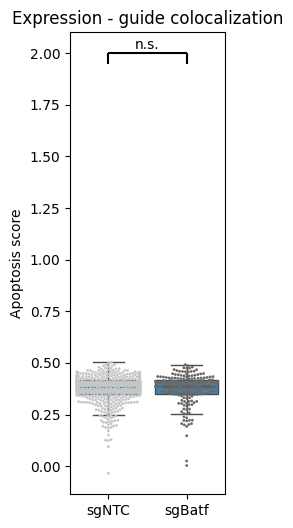

In [92]:
from scipy.stats import spearmanr, pearsonr, f_oneway

# gene_vec = fdata[:, 'Sirt1'].X.toarray().flatten()
ntc_vec = fdata[gdata[:, 'sgnon-targeting'].X > 0].obs['apoptosis_score'].tolist()
guide_vec = fdata[gdata[:, 'sgBatf'].X > 0].obs['apoptosis_score'].tolist()

print(f_oneway(ntc_vec, guide_vec))

import seaborn as sns
plt.figure(figsize=(2,6))
sns.boxplot([ntc_vec, guide_vec], palette='Blues', fliersize=0)
sns.swarmplot([ntc_vec, guide_vec], palette='Greys', size=2)
plt.title('Expression - guide colocalization')
plt.ylabel('Apoptosis score')
plt.xticks([0, 1], ['sgNTC', 'sgBatf'])
plt.hlines(xmin=0, xmax=1, y=2, color='black')
plt.vlines(x=0, ymin=1.95, ymax=2, color='black')
plt.vlines(x=1, ymin=1.95, ymax=2, color='black')
plt.text(x=0.5, ha='center', y=2.02, s='n.s.')
# plt.gca().set_yscale('log')

F_onewayResult(statistic=7.259461043958884, pvalue=0.007219777488260764)


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 2.02, '***')

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


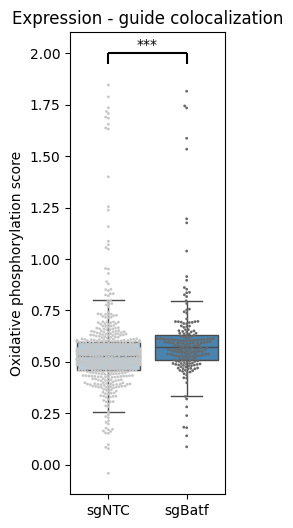

In [90]:
from scipy.stats import spearmanr, pearsonr, f_oneway

# gene_vec = fdata[:, 'Sirt1'].X.toarray().flatten()
ntc_vec = fdata[gdata[:, 'sgnon-targeting'].X > 0].obs['oxidative_score'].tolist()
guide_vec = fdata[gdata[:, 'sgBatf'].X > 0].obs['oxidative_score'].tolist()

print(f_oneway(ntc_vec, guide_vec))

import seaborn as sns
plt.figure(figsize=(2,6))
sns.boxplot([ntc_vec, guide_vec], palette='Blues', fliersize=0)
sns.swarmplot([ntc_vec, guide_vec], palette='Greys', size=2)
plt.title('Expression - guide colocalization')
plt.ylabel('Oxidative phosphorylation score')
plt.xticks([0, 1], ['sgNTC', 'sgBatf'])
plt.hlines(xmin=0, xmax=1, y=2, color='black')
plt.vlines(x=0, ymin=1.95, ymax=2, color='black')
plt.vlines(x=1, ymin=1.95, ymax=2, color='black')
plt.text(x=0.5, ha='center', y=2.02, s='***')
# plt.gca().set_yscale('log')

# PERMANOVA

In [11]:
fdata, gdata = utils.align_rna_guide_data(fdata, gdata)

In [12]:
gdata = gdata[:, gdata.var_names.str.startswith("sg")].copy()

In [14]:
gdata.obs["cluster"] = fdata.obs["cluster"].tolist()

In [40]:
for guide in gdata.var_names:
    if guide == "sgNon-targeting": continue
    g_df = c_df[[guide, "sgNon-targeting", "cluster"]]
    print(g_df)
    break

               sgAckr3  sgNon-targeting  cluster
cov                                             
A_10049-10049        0                0        8
A_10049-10148        0                0        8
A_10049-10249        0                0        4
A_10049-10349        0                0        4
A_10049-10450        0                0        4
...                ...              ...      ...
B_949-5150           0                0        4
B_949-5249           0                0        4
B_949-5349           0                0        4
B_949-5449           0                0        1
B_949-5549           0                0        1

[11612 rows x 3 columns]


In [62]:
data = {}
for cluster in g_df.cluster.unique():
    data['guide_' + str(cluster)] = g_df.loc[g_df.cluster == cluster, guide].tolist()
    data['control_' + str(cluster)] = g_df.loc[g_df.cluster == cluster, "sgNon-targeting"].tolist()

In [67]:
sample_ids = list(data.keys())

In [70]:
dist_matrix = np.zeros((len(sample_ids), len(sample_ids)))
for i in tqdm(range(len(sample_ids))):
    for j in range(len(sample_ids)):
        seq1 = np.array(data[sample_ids[i]])
        seq2 = np.array(data[sample_ids[j]])
        dist, _, _, _ = accelerated_dtw(seq1, seq2, dist='euclidean')
        dist_matrix[i, j] = dist
        dist_matrix[j, i] = dist

100%|██████████| 22/22 [10:53<00:00, 29.70s/it]


In [86]:
dm = DistanceMatrix(dist_matrix, ids=sample_ids)
metadata = pd.DataFrame({
    'group': pd.DataFrame(sample_ids)[0].str.split('_').str.get(0).tolist()
}, index=sample_ids)
results = permanova(dm, metadata, column='group')
print(results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      22
number of groups                  2
test statistic             3.345471
p-value                       0.042
number of permutations          999
Name: PERMANOVA results, dtype: object


# Quantile based permutation

In [119]:
# The idea is to extract quantile bins in each cluster for the distribution of guide counts

# We want quantile frequency distribution to normalize the differential distribution of counts between guide and non-targeting control in linear space.
# Divide into quantile bins
n_quantiles = 1000
quantiles = np.linspace(1/ n_quantiles, 1, n_quantiles)
data = np.array([[np.quantile(g_df.loc[g_df.cluster == c, guide], qt) for qt in quantiles] for c in g_df.cluster.unique()] + [[np.quantile(g_df.loc[g_df.cluster == c, "sgNon-targeting"], qt) for qt in quantiles] for c in g_df.cluster.unique()])

In [130]:
sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

In [136]:
dist_matrix = squareform(pdist(data, metric='euclidean'))

In [139]:
metadata = pd.DataFrame({
    'group': ['A'] * 11 + ['B'] * 11
}, index=sample_ids)
dm = DistanceMatrix(dist_matrix, ids=sample_ids)
results = permanova(dm, metadata, column='group')

In [144]:
n_quantiles = 1000
quantiles = np.linspace(1/ n_quantiles, 1, n_quantiles)
for guide in tqdm(gdata.var_names):
    if guide == "sgNon-targeting": continue
    g_df = c_df[[guide, "sgNon-targeting", "cluster"]]

    data = np.array([[np.quantile(g_df.loc[g_df.cluster == c, guide], qt) for qt in quantiles] for c in g_df.cluster.unique()] + \
    [[np.quantile(g_df.loc[g_df.cluster == c, "sgNon-targeting"], qt) for qt in quantiles] for c in g_df.cluster.unique()])
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='euclidean'))
    metadata = pd.DataFrame({
    'group': ['A'] * 11 + ['B'] * 11
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group')
    print(guide, results['p-value'])

  3%|▎         | 1/32 [00:15<07:56, 15.38s/it]

sgAckr3 0.056


  6%|▋         | 2/32 [00:31<07:55, 15.86s/it]

sgBatf 0.077


  9%|▉         | 3/32 [00:48<07:53, 16.33s/it]

sgBcl2 0.094


 12%|█▎        | 4/32 [01:05<07:41, 16.50s/it]

sgBcl2l11 0.145


 16%|█▌        | 5/32 [01:22<07:29, 16.64s/it]

sgBhlhe40 0.006


 19%|█▉        | 6/32 [01:38<07:14, 16.70s/it]

sgCcr1 0.002


 22%|██▏       | 7/32 [01:54<06:51, 16.45s/it]

sgCcr10 0.012


 25%|██▌       | 8/32 [02:11<06:38, 16.62s/it]

sgCcr2 0.006


 28%|██▊       | 9/32 [02:28<06:23, 16.66s/it]

sgCcr4 0.001


 31%|███▏      | 10/32 [02:44<06:02, 16.47s/it]

sgCcr5 0.002


 34%|███▍      | 11/32 [03:01<05:49, 16.64s/it]

sgCcr6 0.003


 38%|███▊      | 12/32 [03:18<05:34, 16.71s/it]

sgCcr7 0.19


 41%|████      | 13/32 [03:35<05:18, 16.78s/it]

sgCd74 0.001


 44%|████▍     | 14/32 [03:52<05:04, 16.89s/it]

sgCxcr1 0.005


 47%|████▋     | 15/32 [04:09<04:47, 16.90s/it]

sgCxcr2 0.001


 50%|█████     | 16/32 [04:25<04:25, 16.59s/it]

sgCxcr3 0.022


 53%|█████▎    | 17/32 [04:42<04:10, 16.70s/it]

sgCxcr4 0.016


 56%|█████▋    | 18/32 [04:58<03:52, 16.62s/it]

sgCxcr5 0.022


 59%|█████▉    | 19/32 [05:15<03:38, 16.78s/it]

sgCxcr6 0.002


 62%|██████▎   | 20/32 [05:33<03:24, 17.08s/it]

sgDdit4 0.001


 66%|██████▌   | 21/32 [05:50<03:07, 17.07s/it]

sgElob 0.166


 69%|██████▉   | 22/32 [06:07<02:50, 17.03s/it]

sgFos 0.002


 72%|███████▏  | 23/32 [06:25<02:35, 17.23s/it]

sgFoxp1 0.017


 75%|███████▌  | 24/32 [06:42<02:17, 17.19s/it]

sgGpr35 0.043


 78%|███████▊  | 25/32 [06:58<01:58, 16.96s/it]

sgHopx 0.132


 81%|████████▏ | 26/32 [07:16<01:42, 17.01s/it]

sgJun 0.015


 84%|████████▍ | 27/32 [07:32<01:24, 16.92s/it]

sgJund 0.043


 88%|████████▊ | 28/32 [07:50<01:09, 17.30s/it]

sgKlf2 0.059


 94%|█████████▍| 30/32 [08:07<00:26, 13.22s/it]

sgTgif1 0.004


 97%|█████████▋| 31/32 [08:24<00:14, 14.16s/it]

sgTox 0.002


100%|██████████| 32/32 [08:41<00:00, 16.31s/it]

sgYbx1 0.018


In [150]:
g_df.groupby('cluster').apply(lambda x: [g_df[s] for s in x])

/tmp/ipykernel_78447/1473318181.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_df.groupby('cluster').apply(lambda x: [g_df[s] for s in x])


cluster
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
5     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
6     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
7     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
8     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
9     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
10    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
dtype: object

In [176]:
def calculate_quantiles(group, quantiles):
    return [np.quantile(group, qt) for qt in quantiles]

In [204]:
n_quantiles = 1000
quantiles = np.linspace(1/ n_quantiles, 1, n_quantiles)
p_value = {}
f_value = {}
for guide in tqdm(gdata.var_names):
    if guide == "sgNon-targeting": continue
    g_df = c_df[[guide, "sgNon-targeting", "cluster"]]

    #data = np.array([[np.quantile(g_df.loc[g_df.cluster == c, guide], qt) for qt in quantiles] for c in g_df.cluster.unique()] + \
    #[[np.quantile(g_df.loc[g_df.cluster == c, "sgNon-targeting"], qt) for qt in quantiles] for c in g_df.cluster.unique()])
    masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
    guide_quantiles = np.array(g_df.groupby('cluster')[guide].apply(lambda group: calculate_quantiles(group, quantiles)).values.tolist())
    non_targeting_quantiles = np.array(g_df.groupby('cluster')['sgNon-targeting'].apply(lambda group: calculate_quantiles(group, quantiles)).values.tolist())
    data = np.vstack([guide_quantiles, non_targeting_quantiles])[:, -100:]
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='euclidean'))
    metadata = pd.DataFrame({
        'group': ['A'] * 11 + ['B'] * 11
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group', permutations=999)
    #print(guide, results['p-value'])
    p_value[guide] = results['p-value']
    f_value[guide] = results['test statistic']

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [05:01<00:00,  9.41s/it]


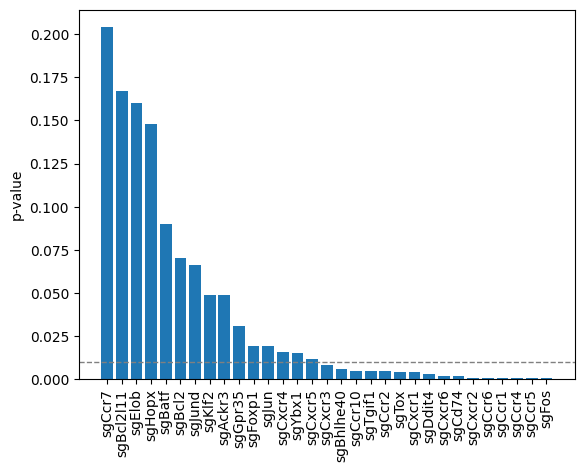

In [203]:
p_df = pd.DataFrame(p_value.values(), index=p_value.keys()).sort_values(by=0, ascending=False)
plt.bar(p_df.index, p_df[0])
plt.axhline(y=0.01, color='gray', linewidth=1, linestyle='--')
plt.xticks(rotation=90)
plt.ylabel('p-value')
plt.show()

In [18]:
chemokine_list = ["sgCcr1", "sgCcr2", "sgCcr4", "sgCcr5", "sgCcr6",
    "sgCcr7", "sgCcr10", "sgCxcr1", "sgCxcr2", "sgCxcr3", "sgCxcr4",
    "sgAckr3", "sgCxcr5", "sgCxcr6", "sgCd74", "sgGpr35", 'sgnon-targeting']
chem_data = gdata[:, chemokine_list].copy()

In [19]:
c_df = pd.concat([pd.DataFrame(chem_data.X, columns=chem_data.var_names, index=chem_data.obs_names), chem_data.obs.cluster], axis=1)

In [20]:
p_value = {}
f_value = {}
for guide in tqdm(chem_data.var_names):
    if guide == "sgnon-targeting": continue
    g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

    masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
    df = pd.DataFrame(columns=range(10))

    guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting']], axis=0).fillna(0))
    ntc_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide]], axis=0).fillna(0))
    data = np.vstack([guide_cnts, ntc_cnts])
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='euclidean'))
    metadata = pd.DataFrame({
        'group': ['A'] * 11 + ['B'] * 11
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group', permutations=999)
    #print(guide, results['p-value'])
    p_value[guide] = results['p-value']
    f_value[guide] = results['test statistic']

  0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipykernel_12409/2562508015.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting']], axis=0).fillna(0))
/tmp/ipykernel_12409/2562508015.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting']], axis=0).fillna(0))
/tmp/ipykernel_12409/2562508015.py:11: FutureWarning: The behavior

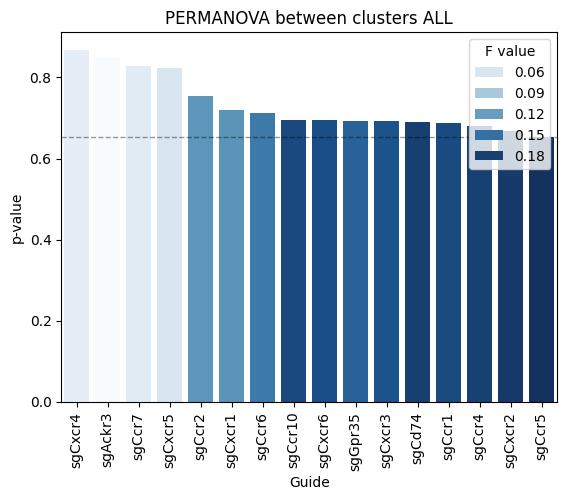

In [21]:
p_df = pd.DataFrame(p_value.values(), index=p_value.keys()).sort_values(by=0, ascending=False)
p_df['f_value'] = pd.DataFrame(f_value, index=['f_value']).T.loc[p_df.index]['f_value'].tolist()
sns.barplot(p_df, x=p_df.index, y=0, hue='f_value', palette='Blues', legend=True)
plt.axhline(y=p_df[0].min(), color='black', linewidth=1, linestyle='--', alpha=0.4)
plt.title('PERMANOVA between clusters ALL')
plt.xlabel('Guide')
plt.legend(title='F value', loc='upper right')
plt.xticks(rotation=90)
plt.ylabel('p-value')
plt.show()